In [4]:
 import boto3
from io import BytesIO
import pypdfium2 as pdfium 
#from IPython.display import display, HTML #only need for domino
import os
import re
from transformers import AutoTokenizer, pipeline, Blip2Processor, Blip2ForConditionalGeneration, BitsAndBytesConfig
from PIL import Image
import torch
import bitsandbytes

# goal
# 1) pick 2 or 3 language models that do image annotations 
# 2) run them on small sample of images from appraisals
# 3) manually look at annotations and evaluate performance


In [5]:
def read_from_s3(file_name):
    """
    Read one file in at a time.
    """
    s3 = boto3.client("s3")
    bucket = 'a1156-val'
    data_key = f"backend_appraisals/sample_data/{file_name}.pdf"
    data_location = 's3://{}/{}'.format(bucket, data_key) 

    pdf_file = s3.get_object(Bucket = bucket, Key = data_key)[
        "Body"
    ].read()

    return pdf_file


def extract_images(file_name): 
    """
    Extract all images from a pdf and store in a list. 
    """
    all_images = []
    pdf = pdfium.PdfDocument(BytesIO(read_from_s3(file_name)))

    for i in range(len(pdf)):
        page = pdf[i]
        
        for obj in page.get_objects(): 
            if obj.type == 3: 
                image = obj.get_bitmap().to_pil() 
                all_images.append(image)

    return all_images
        
    
# def extract_images_and_nearby_text(file_name): 
#     """
#     Extracts images and nearby text from each page and returns a list of dictionaries 
#     with each image and nearby text (if applicable). 
#     """
#     pdf = pdfium.PdfDocument(BytesIO(read_from_s3(file_name)))
#     images_and_text_all_pages = []

#     #loop through every page in pdf
#     for i in range(len(pdf)):
#         page = pdf[i] 
#         images_with_positions = [] 

#         #extract each image and position 
#         for obj in page.get_objects(): 
#             if obj.type == 3: 
#                 image = obj.get_bitmap().to_pil() 
#                 pos = obj.get_pos() 
#                 images_with_positions.append((image, pos)) 

#         if images_with_positions:
#             page_text = page.get_textpage()
#             #images_and_text = []

#             for image, pos in images_with_positions:
#                 #expand the image box to the right 
#                 expanded_box = (pos[0], pos[1] + 150, pos[2] + 250, pos[3])
#                 nearby_text = page_text.get_text_bounded(*expanded_box)

#                 images_and_text_all_pages.append({
#                     'image': image,
#                     'label': nearby_text
#                 })

#             #images_and_text_all_pages.append(images_and_text)

#     return images_and_text_all_pages

# extracted_images_and_labels = extract_images_and_nearby_text("appraisal_sf")
# #list comprehension to filter
# subject_images = [x for x in extracted_images_and_labels if "comparable" not in x['label'].lower()][3:]


# pipeline captioner
def captioner(data_dict, hf_model): 
    captioner = pipeline("image-to-text", model = hf_model)

    for item in data_dict:
        pil_image = item['image']
        label = item['label']
        caption = captioner(pil_image)
        print(f"Label: {label}, Generated Caption: {caption[0]['generated_text']}")
        #pil_image.close()


def mm_generate_caption(pil_image):

    inputs = processor(images=pil_image, return_tensors="pt")
    generated_ids = model.generate(**inputs)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    return generated_text


def answer_prompt(pil_image, prompt):

    inputs = processor(images=pil_image, text = prompt, return_tensors="pt")

    generated_ids = model.generate(**inputs, max_new_tokens = 20)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    return generated_text



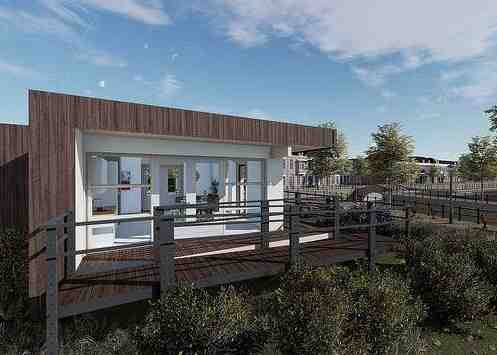

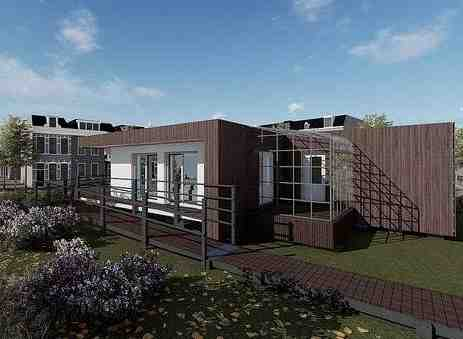

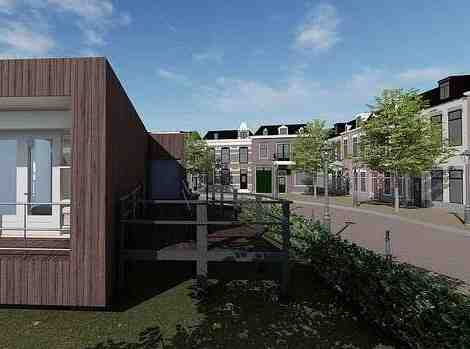

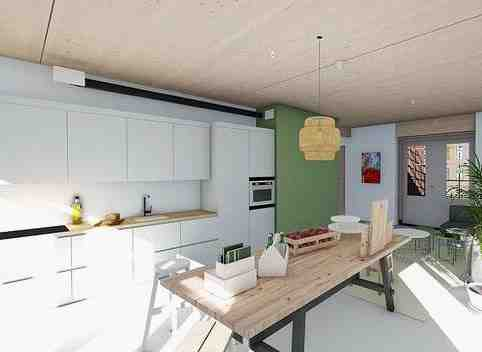

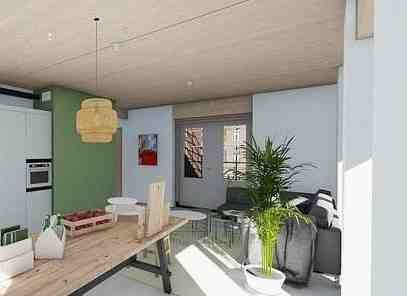

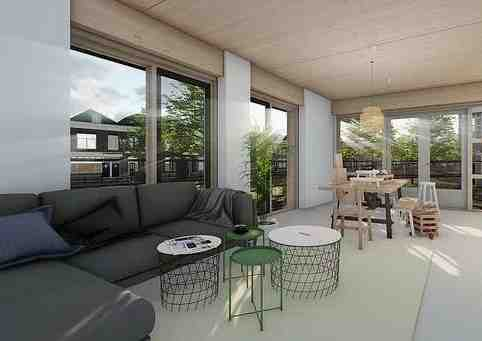

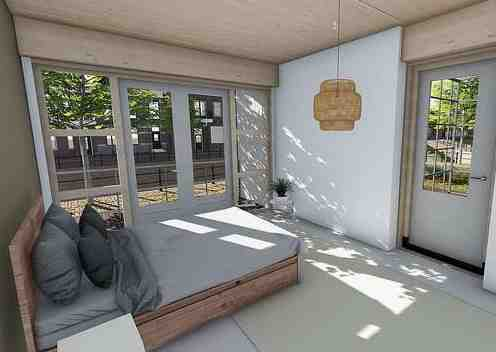

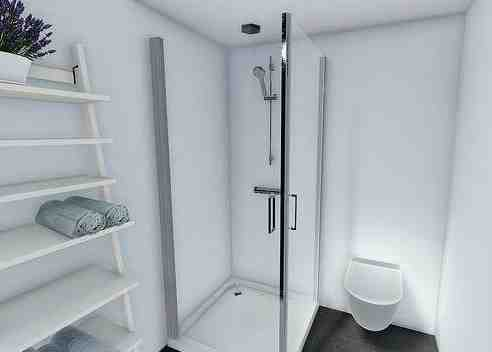

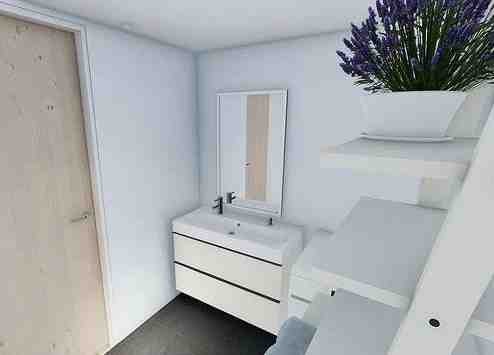

In [6]:
extracted_images_sf = extract_images("appraisal_sf")
#applicable to subject property - keep manual for now including labels since sample doc different format
subject_images_sf = extracted_images_sf[3:12]

labels_sf = [ 'subject front', 'subject rear', 'subject street', 'kitchen', 'nook', 'living/dining', 'bedroom', 'bathroom', 'bathroom']

labeled_images_sf = [{'image':img, 'label': lbl} for img, lbl in zip(subject_images_sf, labels_sf)]

for image in subject_images_sf: 
    image.show()



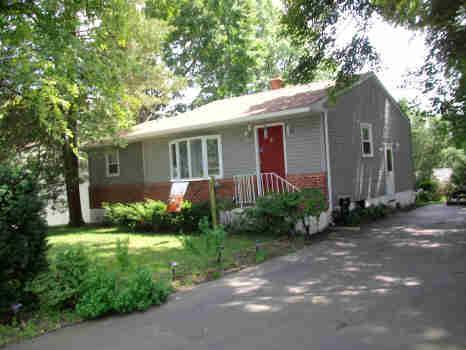

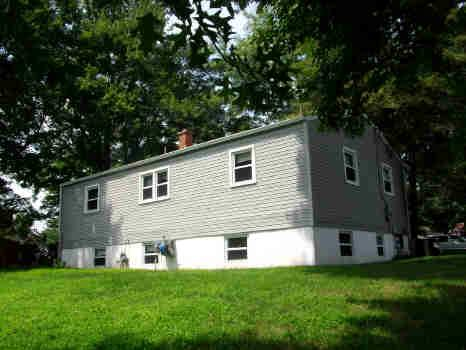

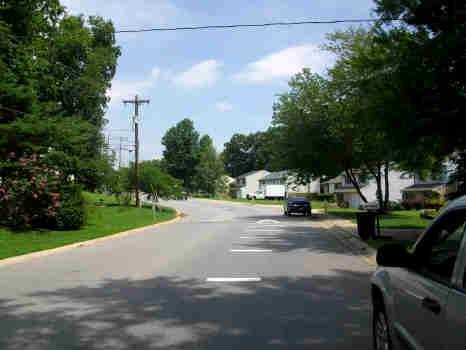

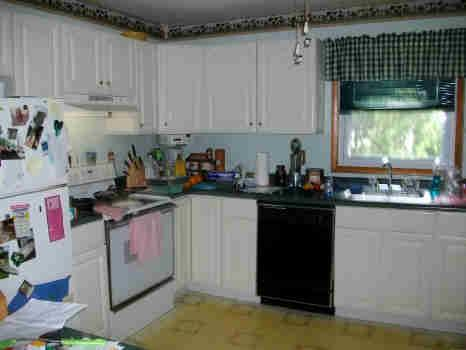

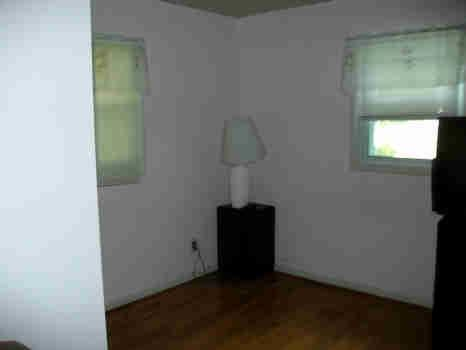

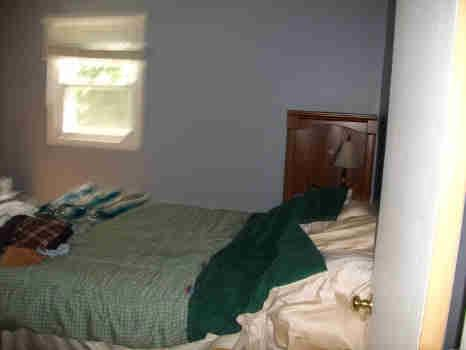

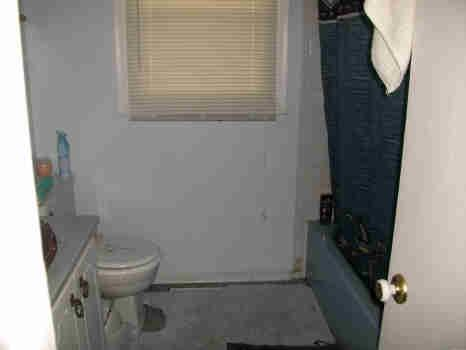

In [7]:
extracted_images_fha = extract_images("fha_appraisal")
#applicable to subject property - keep manual for now including labels since sample doc different format
subject_images_fha = extracted_images_fha[11:18]

labels_fha = ['Subject Front', 'Subject Rear', 'Subject Street', 'Interior', 'Interior', 'Interior', 'Interior']

labeled_images_fha = [{'image':img, 'label': lbl} for img, lbl in zip(subject_images_fha, labels_fha)]

for image in subject_images_fha: 
    image.show()


In [8]:
######################################## BLIP LARGE #####################################################
# bootstrapping langugage-image pre-training = BLIP (general image captioning) - trained on clean and noisy web data 
# large built with a vit-l backbone --> winner at room type and can tell if it's modern but we need to see about condition

# NICE HOUSE
# blip_large_output_sf = captioner(labeled_images_sf,  "Salesforce/blip-image-captioning-large")
# blip_large_output_sf

# Label: subject front, Generated Caption: rendering of a modern home with a deck and a covered patio
# Label: subject rear, Generated Caption: rendering of a modern home with a garden and walkway
# Label: subject street, Generated Caption: rendering of a small house with a balcony and a balcony
# Label: kitchen, Generated Caption: there is a kitchen with a table and chairs in it
# Label: nook, Generated Caption: there is a table with chairs and a plant in a room
# Label: living/dining, Generated Caption: there is a living room with a couch, table, chairs and a television
# Label: bedroom, Generated Caption: there is a bed in a room with a lot of windows
# Label: bathroom, Generated Caption: there is a white bathroom with a toilet and a shower
# Label: bathroom, Generated Caption: there is a white bathroom with a sink and a mirror



# FHA
# large built with a vit-l backbone --> winner

# blip_large_output_fha = captioner(labeled_images_fha,  "Salesforce/blip-image-captioning-large")
# blip_large_output_fha

# NOTE: fairly accurate at room type but not great at providing detail / cant pick up on condition
# Label: Subject Front, Generated Caption: this is a house with a red door and a red door
# Label: Subject Rear, Generated Caption: there is a house that is sitting in the grass
# Label: Subject Street, Generated Caption: cars parked on the side of the road in a residential area
# Label: Interior, Generated Caption: there is a kitchen with a refrigerator, stove, sink and a window
# Label: Interior, Generated Caption: there is a small room with a television and a lamp
# Label: Interior, Generated Caption: there is a bed with a green blanket and a green blanket on it
# Label: Interior, Generated Caption: there is a bathroom with a toilet, sink, and bathtub


In [9]:
######################################## BLIP2 CAPTION #######################################################
# zero shot image to text gen

# processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto")

# NICE HOUSE
# for item in labeled_images_sf:
#     pil_image = item['image']
#     label = item['label']
#     caption = mm_generate_caption(pil_image)
#     print(f"Label: {label}, Generated Caption: {caption}")

# NOTES: on par with blip large but cleaner (maybe slightly less detail. should see with a distresed property)
# Label: subject front, Generated Caption: a rendering of a modern house with a deck
# Label: subject rear, Generated Caption: a rendering of a modern house with a deck
# Label: subject street, Generated Caption: a rendering of a modern house with a balcony
# Label: kitchen, Generated Caption: a kitchen with a table and chairs in it
# Label: nook, Generated Caption: a kitchen and dining area in a modern home
# Label: living/dining, Generated Caption: a modern living room with a couch, coffee table and a dining table
# Label: bedroom, Generated Caption: a 3d rendering of a bedroom with a bed and a window
# Label: bathroom, Generated Caption: a bathroom with a shower, toilet and shelf
# Label: bathroom, Generated Caption: a bathroom with a sink, toilet and a potted plant



# for item in labeled_images_fha:
#     pil_image = item['image']
#     label = item['label']
#     caption = mm_generate_caption(pil_image)
#     print(f"Label: {label}, Generated Caption: {caption}")

# NOTE: better at the text out (clearer)
#Label: Subject Front, Generated Caption: a house with a driveway and trees in the yard
# Label: Subject Rear, Generated Caption: a gray house with a large yard and trees
# Label: Subject Street, Generated Caption: a street with trees and houses on both sides
# Label: Interior, Generated Caption: a kitchen with a refrigerator, stove and sink
# Label: Interior, Generated Caption: a room with a lamp, a window and a hardwood floor
# Label: Interior, Generated Caption: a bed with a green comforter and a white nightstand
# Label: Interior, Generated Caption: a bathroom with a toilet, tub and window


In [10]:
######################################## BLIP2 VQA #####################################################

# need to fine-tine blip2 on kaggle home data - it thinks every house is in good condition and nothing is wrong when clearly there is a big difference

# for item in labeled_images_sf:
#     pil_image = item['image']
#     label = item['label']
#     response = answer_prompt(pil_image, "Question: Is there is any wall damage, furniture, mold or other special attributes. Answer:")
#     print(response)



# for item in labeled_images_fha:
#     pil_image = item['image']
#     label = item['label']
#     response = answer_prompt(pil_image, "Question: Is there any furniture in the room? Answer:")
#     print(response)


In [11]:
######################################## LLAVA ####################################################
# object detection

from transformers import AutoProcessor, LlavaForConditionalGeneration
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig( 
    load_in_4bit = True, 
    bnb_4bit_compute_dtype=torch.float16
)

# model_id = "llava-hf/llava-1.5-7b-hf"

# processor = AutoProcessor.from_pretrained(model_id)
# model = LlavaForConditionalGeneration.from_pretrained(model_id, device_map="auto")



# def captioner(data_dict, hf_model): 
#     captioner = pipeline("image-to-text", model = hf_model)

#     for item in data_dict:
#         pil_image = item['image']
#         label = item['label']
#         caption = captioner(pil_image)
#         print(f"Label: {label}, Generated Caption: {caption[0]['generated_text']}")
#         #pil_image.close()


# def mm_generate_caption(pil_image):

#     inputs = processor(images=pil_image, return_tensors="pt")
#     generated_ids = model.generate(**inputs)
#     generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
#     return generated_text




# pipe = pipeline("image-to-text", model=model_id)


# max_new_tokens = 200
# prompt = "USER: <image>\nPlease describe this image in detail - what room is it and what is the condition?\nASSISTANT:"
# outputs = pipe(pil_image, prompt = prompt, generate_kwargs={"max_new_tokens":200})
#     #print(outputs[0]["generated_text"])


# for item in labeled_images_sf:
#     pil_image = item['image']
#     label = item['label']
#     caption = generate_caption(pil_image)
#     print(f"Label: {label}, Generated Caption: {outputs[0]['generated_text']}")
#         #pil_image.close()




In [13]:
#APPENDINX

###################################  BLIP Base #######################################
# bootstrapping langugage-image pre-training = BLIP (general image captioning) - trained on clean and noisy web data (vit backbone)
# visual transformer is image encoder and text transformer is encoder-decoder

# blip_base_output_sf = captioner(labeled_images_sf,  "Salesforce/blip-image-captioning-large")
# blip_base_output_sf


# Label: subject front, Generated Caption: a rendering of a house on a hill
# Label: subject rear, Generated Caption: a rendering of a house with a garden and a walkway
# Label: subject street, Generated Caption: a rendering of a small house in the middle of a town --> town is interesting lol
# Label: kitchen, Generated Caption: a kitchen and dining area in a modern apartment
# Label: nook, Generated Caption: a room with a table and chairs in it
# Label: living/dining, Generated Caption: a living room with a couch and a table
# Label: bedroom, Generated Caption: a room with a couch and a window
# Label: bathroom, Generated Caption: a bathroom with a toilet and shelves
# Label: bathroom, Generated Caption: a white bed --> wrong





####################  generativeimage2text(git) from microsoft #############################
# base was terrible; large was too large and i think blip large was better anyway

# git_output_sf = captioner(labeled_images_sf,  "microsoft/git-base")
# git_output_sf

# Label: subject front, Generated Caption: the building is white
# Label: subject rear, Generated Caption: the house in the middle of the street
# Label: subject street, Generated Caption: the house is the pink one in the middle
# Label: kitchen, Generated Caption: white kitchen cabinets
# Label: nook, Generated Caption: the window in the room
# Label: living/dining, Generated Caption: a large window
# Label: bedroom, Generated Caption: the house is on the market for $ 3. 5 million.
# Label: bathroom, Generated Caption: a white shower stall
# Label: bathroom, Generated Caption: a mirror on the wall


##########################################  VIT GP2 ######################################
#vit gpt2 (multimodal - combined vision transformer and gpt2 for text generation)

# vit_gpt2_output_sf = captioner(labeled_images_sf,  "nlpconnect/vit-gpt2-image-captioning")
# vit_gpt2_output_sf


#NOTE: This was fine but BLIP was better
# Label: subject front, Generated Caption: a white and black dog standing in front of a fence --> wrong
# Label: subject rear, Generated Caption: a large building with a large window on top 
# Label: subject street, Generated Caption: a building with a fence and a bench in front of it 
# Label: kitchen, Generated Caption: a kitchen with a table and a stove 
# Label: nook, Generated Caption: a kitchen with a table and a plant 
# Label: living/dining, Generated Caption: a living room with a couch, chairs, and a table 
# Label: bedroom, Generated Caption: a large room with a couch and a window 
# Label: bathroom, Generated Caption: a bathroom with a toilet and a shower 
# Label: bathroom, Generated Caption: a bathroom with a sink, toilet and bathtub 

In [ ]:
######################################## FLORENCE ###################################################

# From Microsoft. Note I did not use this mode because: 
# ImportError: This modeling file requires the following packages that were not found in your environment: einops, flash_attn. Run `pip install einops flash_attn`
    # So i pip install BUT then i get this error in the terminal because no .git in sandbox --> fatal: not a git repository (or any of the parent directories): 
    # .git/tmp/pip-install-43kvk0cx/flash-attn_86c0cdde231f434284c2f2f8373f2f1b/setup.py:95: UserWarning: flash_attn was requested,
    # but nvcc was not found.  Are you sure your environment has nvcc available?  If you're installing within a container from https://hub.docker.com/r/pytorch/pytorch, 
    # only images whose names contain 'devel' will provide nvcc.



# import requests
# from PIL import Image
# from transformers import AutoProcessor, AutoModelForCausalLM 

# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

# model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base")
# processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", device_map="auto", trust_remote_code=True)

# prompt = "<OD>"

# inputs = processor(text=prompt, images=labeled_images_sf[0], return_tensors="pt").to(device, torch_dtype)

# generated_ids = model.generate(
#     input_ids=inputs["input_ids"],
#     pixel_values=inputs["pixel_values"],
#     max_new_tokens=1024,
#     do_sample=False,
#     num_beams=3,
# )
# generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

# parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

# print(parsed_answer)
